# Potential Predictor

- Model that predicts the potential from a player
- answers question: how does fifa predict the attribute potential?

In [200]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "potential_center_forward"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80
MINDEST_POTENTIAL = 0
CENTRAL = 1
OFFENSE = 1

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']

PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','Composure','Age',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'BallControl','ShotPower', 'Positioning', 
         'HeadingAccuracy']

# PLAYER_ATTRIBUTES = ['FKAccuracy','HeadingAccuracy',
#        'ShortPassing',  'Dribbling',  
#         'BallControl',  'SprintSpeed', 
#        'Reactions',    'Strength',
#        'LongShots', 'Aggression',  'Positioning'
# ]


In [201]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/872322974777381431', creation_time=1703506837921, experiment_id='872322974777381431', last_update_time=1703506837921, lifecycle_stage='active', name='potential_center_forward', tags={}>

### Get Data

In [202]:
sql_raw = """
SELECT *
  FROM fifa
Where Age < 20
  """



In [203]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_raw = pd.read_sql_query(sql_raw, conn)


conn.close()

# df_raw = df_raw.set_index(['ID'])
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,...,Body type,Real face,birthDate,league,club_prestige,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
186627,M. Balotelli,2011,19.0,https://cdn.sofifa.net/players/186/627/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,81.0,87.0,Manchester City,https://cdn.sofifa.net/meta/team/9/30.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,18.0
194963,André,2011,19.0,https://cdn.sofifa.net/players/194/963/11_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,76.0,79.0,None,https://cdn.sofifa.net/flags/br.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,31.0
184467,N. Delfouneso,2011,19.0,https://cdn.sofifa.net/players/184/467/11_60.png,England,https://cdn.sofifa.net/flags/gb-eng.png,76.0,85.0,Aston Villa,https://cdn.sofifa.net/meta/team/15/30.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,19.0
192505,R. Lukaku,2011,17.0,https://cdn.sofifa.net/players/192/505/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,74.0,88.0,Anderlecht,https://cdn.sofifa.net/meta/team/2555/30.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,17.0
186140,F. Macheda,2011,18.0,https://cdn.sofifa.net/players/186/140/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,74.0,88.0,Manchester United,https://cdn.sofifa.net/meta/team/14/30.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,19.0


# 

In [204]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [205]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [206]:
df = df[(df.central == CENTRAL)&(df.offense ==OFFENSE)]


# df = df[df.PrimeOverall>df.Overall]
df['target'] = df.Potential

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
74.0    318
68.0    314
67.0    277
75.0    274
69.0    271
70.0    271
72.0    263
76.0    242
66.0    231
71.0    230
77.0    214
65.0    206
73.0    202
64.0    183
78.0    181
79.0    157
80.0    147
63.0    122
81.0    120
62.0     99
58.0     86
82.0     79
60.0     76
59.0     74
61.0     69
57.0     69
83.0     65
84.0     52
85.0     48
56.0     39
55.0     38
86.0     22
54.0     16
87.0     14
88.0     13
52.0      6
53.0      6
51.0      3
89.0      2
94.0      1
92.0      1
91.0      1
93.0      1
Name: count, dtype: int64


###  Feature Engineering

In [207]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Photo', 'Flag', 'Club', 'Club Logo', 'Special', 'Unnamed: 0',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Att. Position',
       'Composure', 'Defensive awareness', 'Preferred foot', 'Skill moves',
       'Weak foot', 'International reputation', 'Work rate', 'Body type',
       'Real face', 'birthDate', 'league', 'club_prestige'],
      dtype='object')

#### Transform Value

In [208]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

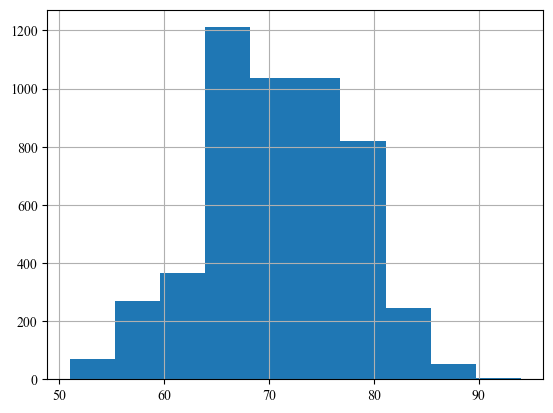

In [209]:
df['target'].hist()

In [210]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [211]:
df_processed.columns

Index(['Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential', 'Club',
       'Club Logo', 'Value', 'Wage', 'Special', 'Position', 'Unnamed: 0',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Att. Position',
       'Composure', 'Defensive awareness', 'Preferred foot', 'Skill moves',
       'Weak foot', 'International reputation', 'Work rate', 'Body type',
       'Real face', 'birthDate', 'league', 'club_prestige', 'best_position',
       'central', 'winger', 'offense', 'Defense', 'set', 'target'],
      dtype='object')

In [212]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [213]:
y_train.describe()

count    3486.000000
mean       70.102697
std         6.900341
min        51.000000
25%        66.000000
50%        70.000000
75%        75.000000
max        94.000000
Name: target, dtype: float64

In [214]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [215]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [216]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [217]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


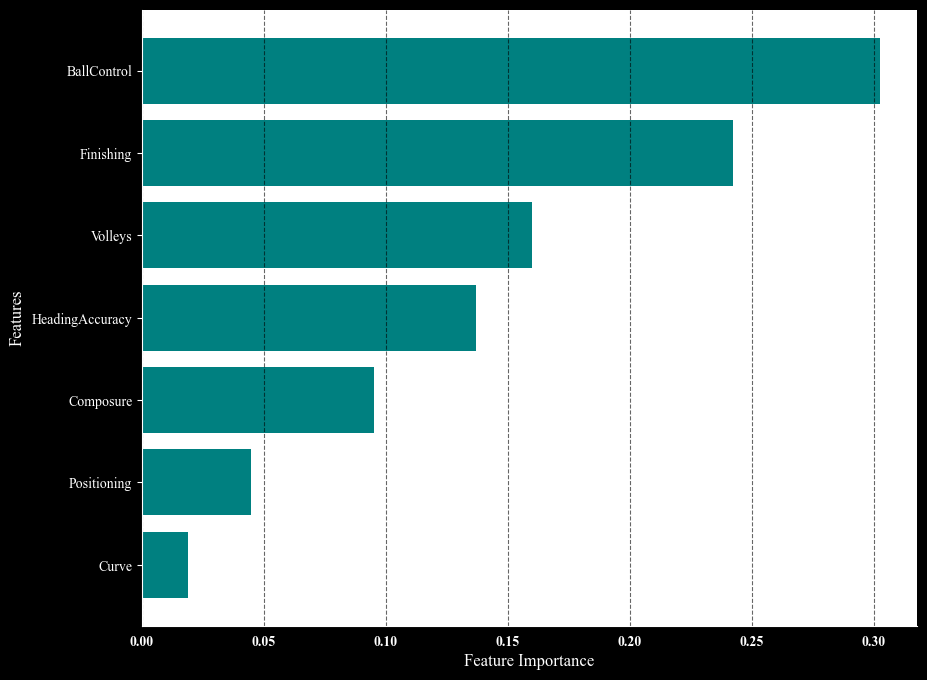

Using 475 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


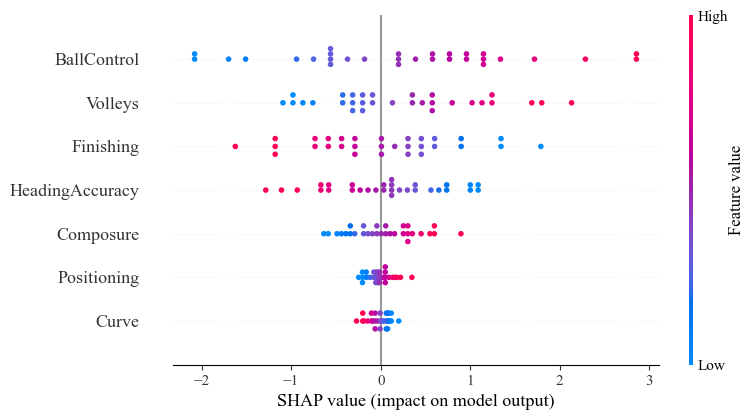

              precision    recall  f1-score   support

       False       0.87      1.00      0.93       411
        True       0.00      0.00      0.00        64

    accuracy                           0.87       475
   macro avg       0.43      0.50      0.46       475
weighted avg       0.75      0.87      0.80       475

Huber Regression training----->


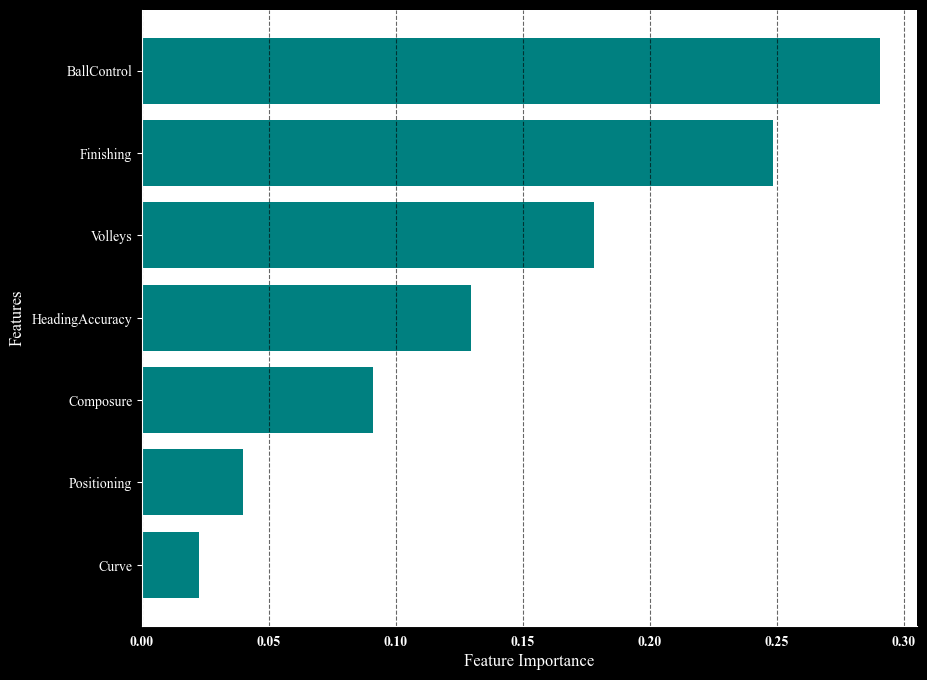

Using 475 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:12<00:00,  2.45it/s]


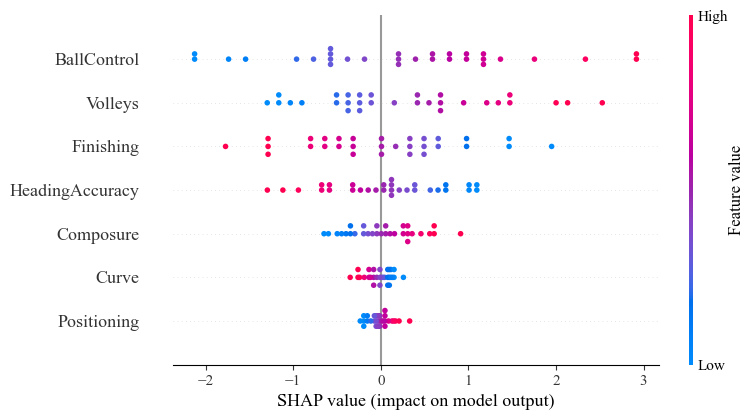

              precision    recall  f1-score   support

       False       0.87      1.00      0.93       411
        True       0.00      0.00      0.00        64

    accuracy                           0.87       475
   macro avg       0.43      0.50      0.46       475
weighted avg       0.75      0.87      0.80       475

Linear Regression training----->


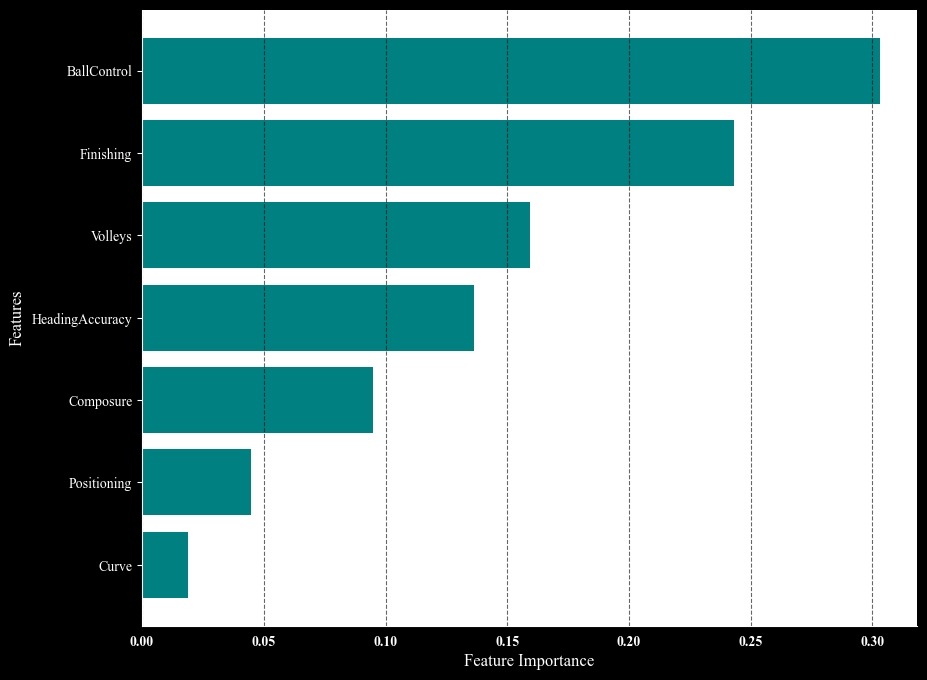

Using 475 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


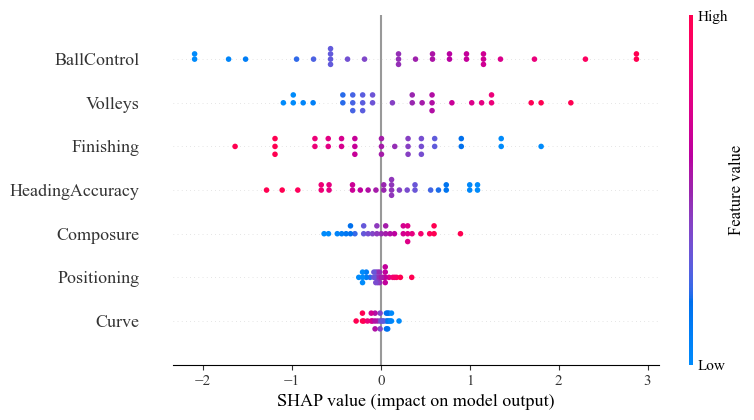

              precision    recall  f1-score   support

       False       0.87      1.00      0.93       411
        True       0.00      0.00      0.00        64

    accuracy                           0.87       475
   macro avg       0.43      0.50      0.46       475
weighted avg       0.75      0.87      0.80       475

Model: Ridge Regression
Mean Squared Error: 30.09
Mean Absolute Error: 4.47
R2 Score: 0.13

Model: Huber Regression
Mean Squared Error: 29.84
Mean Absolute Error: 4.46
R2 Score: 0.14

Model: Linear Regression
Mean Squared Error: 30.09
Mean Absolute Error: 4.47
R2 Score: 0.13



In [218]:



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    #  'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    #  'XGBoost Regressor': XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [219]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [220]:
X_train.describe()

,Crossing,Finishing,Composure,Age,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,ShotPower,Positioning,HeadingAccuracy
count,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000
mean,33.452955,51.609007,19.575445,18.240103,43.128514,41.905622,48.547045,37.962134,32.328744,48.851692,49.657487,27.913081,47.336776
std,16.616838,21.744005,25.610344,0.814861,19.217299,19.131696,21.338159,17.940528,16.026639,21.231851,21.523782,28.029451,20.741952
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,52.000000,0.000000,18.000000,40.000000,38.000000,46.000000,34.000000,28.000000,47.000000,48.000000,0.000000,45.000000
50%,34.000000,58.000000,0.000000,18.000000,48.000000,46.000000,54.000000,41.000000,33.000000,55.000000,55.000000,40.000000,53.000000
75%,43.000000,64.000000,48.000000,19.000000,55.000000,54.000000,62.000000,48.000000,41.000000,61.000000,62.000000,55.000000,60.000000
max,77.000000,88.000000,82.000000,19.000000,82.000000,82.000000,90.000000,84.000000,80.000000,91.000000,87.000000,81.000000,86.000000


In [221]:
y_test.describe()

count    475.000000
mean      73.978947
std        5.881350
min       59.000000
25%       70.000000
50%       74.000000
75%       78.000000
max       93.000000
Name: target, dtype: float64

In [222]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [223]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

475

<Axes: >

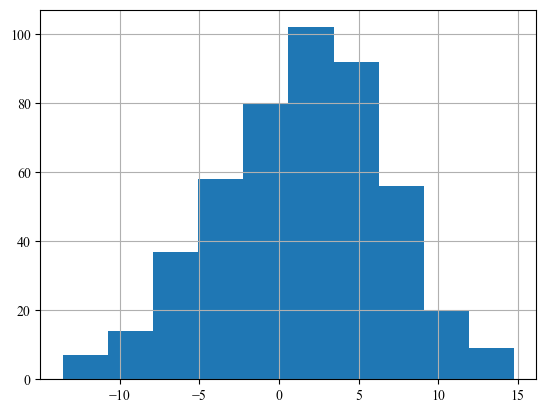

In [224]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

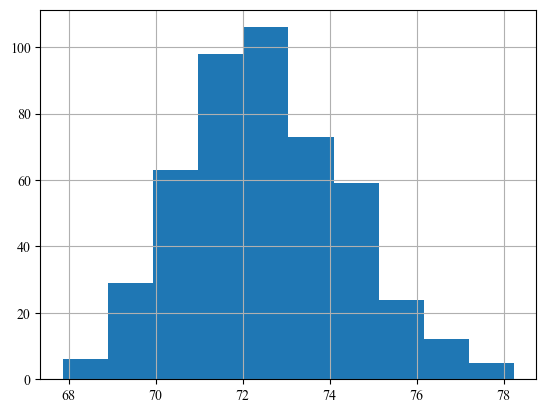

In [225]:
result_df.sort_values(ascending=False).hist()

In [226]:
(y_test-result_df).describe()

count    475.000000
mean       1.461559
std        5.268715
min      -13.577078
25%       -2.148907
50%        1.628446
75%        5.266470
max       14.767707
dtype: float64

In [227]:
outlier = (y_test-result_df)>10
X_test[outlier]


,,,Crossing,Finishing,Composure,Age,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,ShotPower,Positioning,HeadingAccuracy
ID,Name,FIFA,,,,,,,,,,,,,
236610,M. Kean,2020,42.0,77.0,72.0,19.0,59.0,70.0,77.0,66.0,43.0,78.0,72.0,78.0,72.0
245149,J. Hurtado,2020,52.0,67.0,62.0,19.0,66.0,55.0,74.0,46.0,35.0,70.0,71.0,73.0,53.0
245762,A. Kutucu,2020,43.0,70.0,63.0,19.0,64.0,62.0,68.0,53.0,46.0,67.0,78.0,60.0,60.0
240753,A. Gouiri,2020,39.0,69.0,69.0,19.0,65.0,60.0,70.0,59.0,38.0,69.0,68.0,68.0,59.0
240969,J. Carranza,2020,45.0,67.0,62.0,19.0,64.0,45.0,66.0,48.0,44.0,67.0,67.0,72.0,62.0
241487,J. Ferreira,2020,26.0,71.0,66.0,18.0,52.0,40.0,55.0,53.0,27.0,63.0,64.0,74.0,62.0
251198,E. Simms,2020,45.0,66.0,64.0,18.0,54.0,60.0,57.0,54.0,49.0,59.0,64.0,63.0,59.0
248385,R. Piccoli,2020,42.0,67.0,56.0,18.0,55.0,54.0,55.0,41.0,30.0,60.0,62.0,67.0,68.0
245902,T. Parrott,2020,35.0,69.0,60.0,17.0,60.0,53.0,60.0,53.0,48.0,60.0,64.0,65.0,52.0


In [228]:
y_test[outlier]

ID      Name          FIFA
236610  M. Kean       2020    89.0
245149  J. Hurtado    2020    86.0
245762  A. Kutucu     2020    85.0
240753  A. Gouiri     2020    86.0
240969  J. Carranza   2020    85.0
241487  J. Ferreira   2020    83.0
251198  E. Simms      2020    84.0
248385  R. Piccoli    2020    85.0
245902  T. Parrott    2020    85.0
244288  A. Idah       2020    84.0
247122  D. Sikan      2020    83.0
250961  J. Zirkzee    2020    81.0
246123  D. Redan      2020    82.0
243169  Y. Begraoui   2020    82.0
244592  J. von Moos   2020    82.0
239085  E. Haaland    2021    92.0
251852  K. Adeyemi    2021    87.0
247888  S. Esposito   2021    86.0
257612  S. Mara       2021    84.0
242444  João Félix    2020    93.0
243630  J. David      2020    87.0
246147  M. Greenwood  2020    87.0
Name: target, dtype: float64

In [229]:
result_df[outlier]

ID      Name          FIFA
236610  M. Kean       2020    76.359935
245149  J. Hurtado    2020    75.884767
245762  A. Kutucu     2020    74.784079
240753  A. Gouiri     2020    75.514259
240969  J. Carranza   2020    73.131514
241487  J. Ferreira   2020    71.201221
251198  E. Simms      2020    73.797484
248385  R. Piccoli    2020    72.152073
245902  T. Parrott    2020    73.059689
244288  A. Idah       2020    72.435575
247122  D. Sikan      2020    72.194907
250961  J. Zirkzee    2020    70.924507
246123  D. Redan      2020    71.961231
243169  Y. Begraoui   2020    69.554161
244592  J. von Moos   2020    70.238228
239085  E. Haaland    2021    77.284566
251852  K. Adeyemi    2021    76.640077
247888  S. Esposito   2021    73.930361
257612  S. Mara       2021    72.039708
242444  João Félix    2020    78.232293
243630  J. David      2020    75.796910
246147  M. Greenwood  2020    74.982658
dtype: float64

In [230]:
(y_test/result_df).describe()

count    475.000000
mean       1.019864
std        0.072326
min        0.817946
25%        0.970330
50%        1.022816
75%        1.072295
max        1.190406
dtype: float64

In [231]:
(y_test/result_df).describe()

count    475.000000
mean       1.019864
std        0.072326
min        0.817946
25%        0.970330
50%        1.022816
75%        1.072295
max        1.190406
dtype: float64

In [232]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.46958504],
       [0.46958504, 1.        ]])

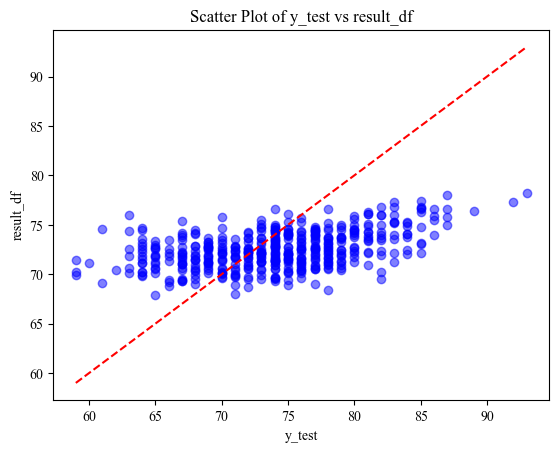

In [233]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [234]:
result_df = result_df.sort_values(ascending=False)

In [235]:
sum(X_train_scaled_df.index.get_level_values('ID')==239085)

1

In [236]:
df_raw

,,,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,...,Body type,Real face,birthDate,league,club_prestige,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
186627,M. Balotelli,2011,19.0,https://cdn.sofifa.net/players/186/627/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,81.0,87.0,Manchester City,https://cdn.sofifa.net/meta/team/9/30.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,18.0
194963,André,2011,19.0,https://cdn.sofifa.net/players/194/963/11_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,76.0,79.0,None,https://cdn.sofifa.net/flags/br.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,31.0
184467,N. Delfouneso,2011,19.0,https://cdn.sofifa.net/players/184/467/11_60.png,England,https://cdn.sofifa.net/flags/gb-eng.png,76.0,85.0,Aston Villa,https://cdn.sofifa.net/meta/team/15/30.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,19.0
192505,R. Lukaku,2011,17.0,https://cdn.sofifa.net/players/192/505/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,74.0,88.0,Anderlecht,https://cdn.sofifa.net/meta/team/2555/30.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,17.0
186140,F. Macheda,2011,18.0,https://cdn.sofifa.net/players/186/140/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,74.0,88.0,Manchester United,https://cdn.sofifa.net/meta/team/14/30.png,€0,€0,...,None,None,None,None,NaN,ST,1,0,1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276387,G. Sandiford,2024,18.0,https://cdn.sofifa.net/players/276/387/24_60.png,England,https://cdn.sofifa.net/flags/gb-eng.png,52.0,58.0,Cambridge United,https://cdn.sofifa.net/meta/team/232/30.png,€110K,€500,...,None,None,None,None,NaN,RB,0,1,-1.0,46.0
277495,A. Al Harbi,2024,19.0,https://cdn.sofifa.net/players/277/495/24_60.png,Saudi Arabia,https://cdn.sofifa.net/flags/sa.png,52.0,66.0,Al Hazem,https://cdn.sofifa.net/meta/team/17694/30.png,€180K,€1K,...,None,None,None,None,NaN,RB,0,1,-1.0,49.0
267920,A. Freeman,2024,18.0,https://cdn.sofifa.net/players/267/920/24_60.png,United States,https://cdn.sofifa.net/flags/us.png,51.0,68.0,Orlando City,https://cdn.sofifa.net/meta/team/204/30.png,€140K,€500,...,None,None,None,None,NaN,RB,0,1,-1.0,43.0


In [237]:
result_df.head(50)

ID      Name               FIFA
242444  João Félix         2020    78.232293
254544  Reinier            2021    77.983581
239085  E. Håland          2020    77.426151
243627  Y. Adli            2021    77.295472
239085  E. Haaland         2021    77.284566
233731  A. Isak            2020    76.816091
252037  Fábio Silva        2021    76.770462
251470  C. De Ketelaere    2021    76.769898
246191  J. Álvarez         2020    76.746791
251852  K. Adeyemi         2021    76.640077
252037  Fábio Silva        2020    76.617950
247447  O. Antman          2021    76.604392
252289  Richard Rodrigues  2020    76.583821
239956  M. Boadu           2020    76.555189
236610  M. Kean            2020    76.359935
239981  J. Arp             2020    76.281259
250807  H. Dervişoğlu      2020    76.258628
240345  I. Kanu            2020    76.108061
252324  Riquelme           2020    76.098428
245639  André Anderson     2020    76.074680
251105  D. Joveljić        2020    76.028031
246044  Andrés Martín  

In [238]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

0


Series([], dtype: float64)

In [239]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

80


ID      Name         FIFA
242444  João Félix   2020    78.232293
254544  Reinier      2021    77.983581
239085  E. Håland    2020    77.426151
243627  Y. Adli      2021    77.295472
239085  E. Haaland   2021    77.284566
                               ...    
244695  A. Ndiaye    2020    71.222514
241487  J. Ferreira  2020    71.201221
250961  J. Zirkzee   2020    70.924507
244592  J. von Moos  2020    70.238228
243169  Y. Begraoui  2020    69.554161
Length: 80, dtype: float64

In [240]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

0


Series([], dtype: float64)

In [241]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

395


ID      Name               FIFA
244762  L. Diaby Fadiga    2020    74.727163
243360  N. Fröling         2020    74.744019
245770  D. Drăguș          2020    74.754892
241650  J. Lahne           2021    74.755428
252469  Diogo Almeida      2020    74.755850
238873  P. Pellegri        2021    74.773960
258275  S. Lauf            2021    74.946126
256530  A. Aravena         2021    75.013023
252960  I. Jansson         2021    75.100736
246401  F. Hartmann        2021    75.205302
246115  M. Valiente        2020    75.241607
250827  B. Aveiro          2021    75.274169
247139  A. Owusu           2020    75.370594
245067  Y. Taki            2020    75.459604
241266  W. Geubbels        2021    75.667850
236706  P. Almqvist        2020    75.810593
255680  D. Torres          2021    76.024557
240345  I. Kanu            2020    76.108061
252289  Richard Rodrigues  2020    76.583821
247447  O. Antman          2021    76.604392
dtype: float64

In [242]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.67      1.00      0.80       289
        True       0.98      0.23      0.37       186

    accuracy                           0.70       475
   macro avg       0.82      0.61      0.59       475
weighted avg       0.79      0.70      0.63       475



In [243]:
X_train[X_train.index.get_level_values('ID')==239085]

,,,Crossing,Finishing,Composure,Age,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,ShotPower,Positioning,HeadingAccuracy
ID,Name,FIFA,,,,,,,,,,,,,
239085,E. Håland,2018,42.0,59.0,48.0,16.0,46.0,51.0,58.0,67.0,33.0,57.0,56.0,53.0,56.0
